In [127]:
cd /

/


In [128]:
font = "/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf"
left_file = "man.mp4" 
right_file = "vine_01.mp4"

video_root = "/Users/troydo42/Desktop/Body_Matrixes"
date = "Dec12"
min_accuracy = 0.9
sample_index = 10

In [129]:
output_image = date + "_Body_Matrix_Scores_" + left_file[0:-4] + "_vs_" + right_file[0:-4] + ".png"
output_video = date + "_Body_Matrix_Scores_" + left_file[0:-4] + "_vs_" + right_file[0:-4] + ".mp4"

print(output_image, output_video)

Dec12_Body_Matrix_Scores_man_vs_vine_01.png Dec12_Body_Matrix_Scores_man_vs_vine_01.mp4


In [130]:
import os
output_folder = os.path.join(video_root, date)
left_video_path = os.path.join(video_root, date, left_file)
right_video_path = os.path.join(video_root, date, right_file)

In [131]:
### Loading Video
import os
import av
import math
import random
from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image

def load_video(video_path, rotate):
    video, audio, meta = read_video(video_path, pts_unit="sec", output_format="TCHW")
    frame_counts = len(video)
    fps = meta['video_fps']
    print(frame_counts, fps)
    sample_frame = to_pil_image(video[sample_index])
    sample_frame = sample_frame.rotate(rotate, expand=True)
    return video, frame_counts, fps, sample_frame

33 29.889322869663783


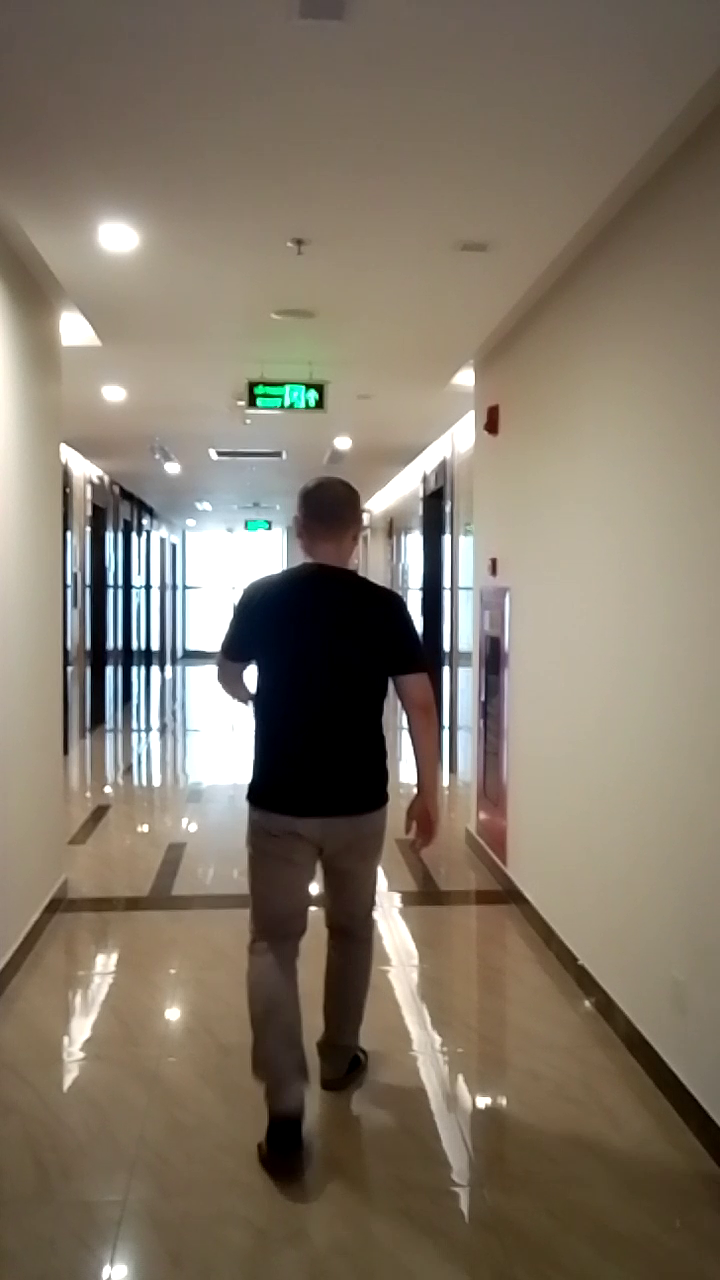

In [132]:
left_vid, left_counts, left_fps, left_sample = load_video(left_video_path, 90)
left_sample

32 29.88078810578629


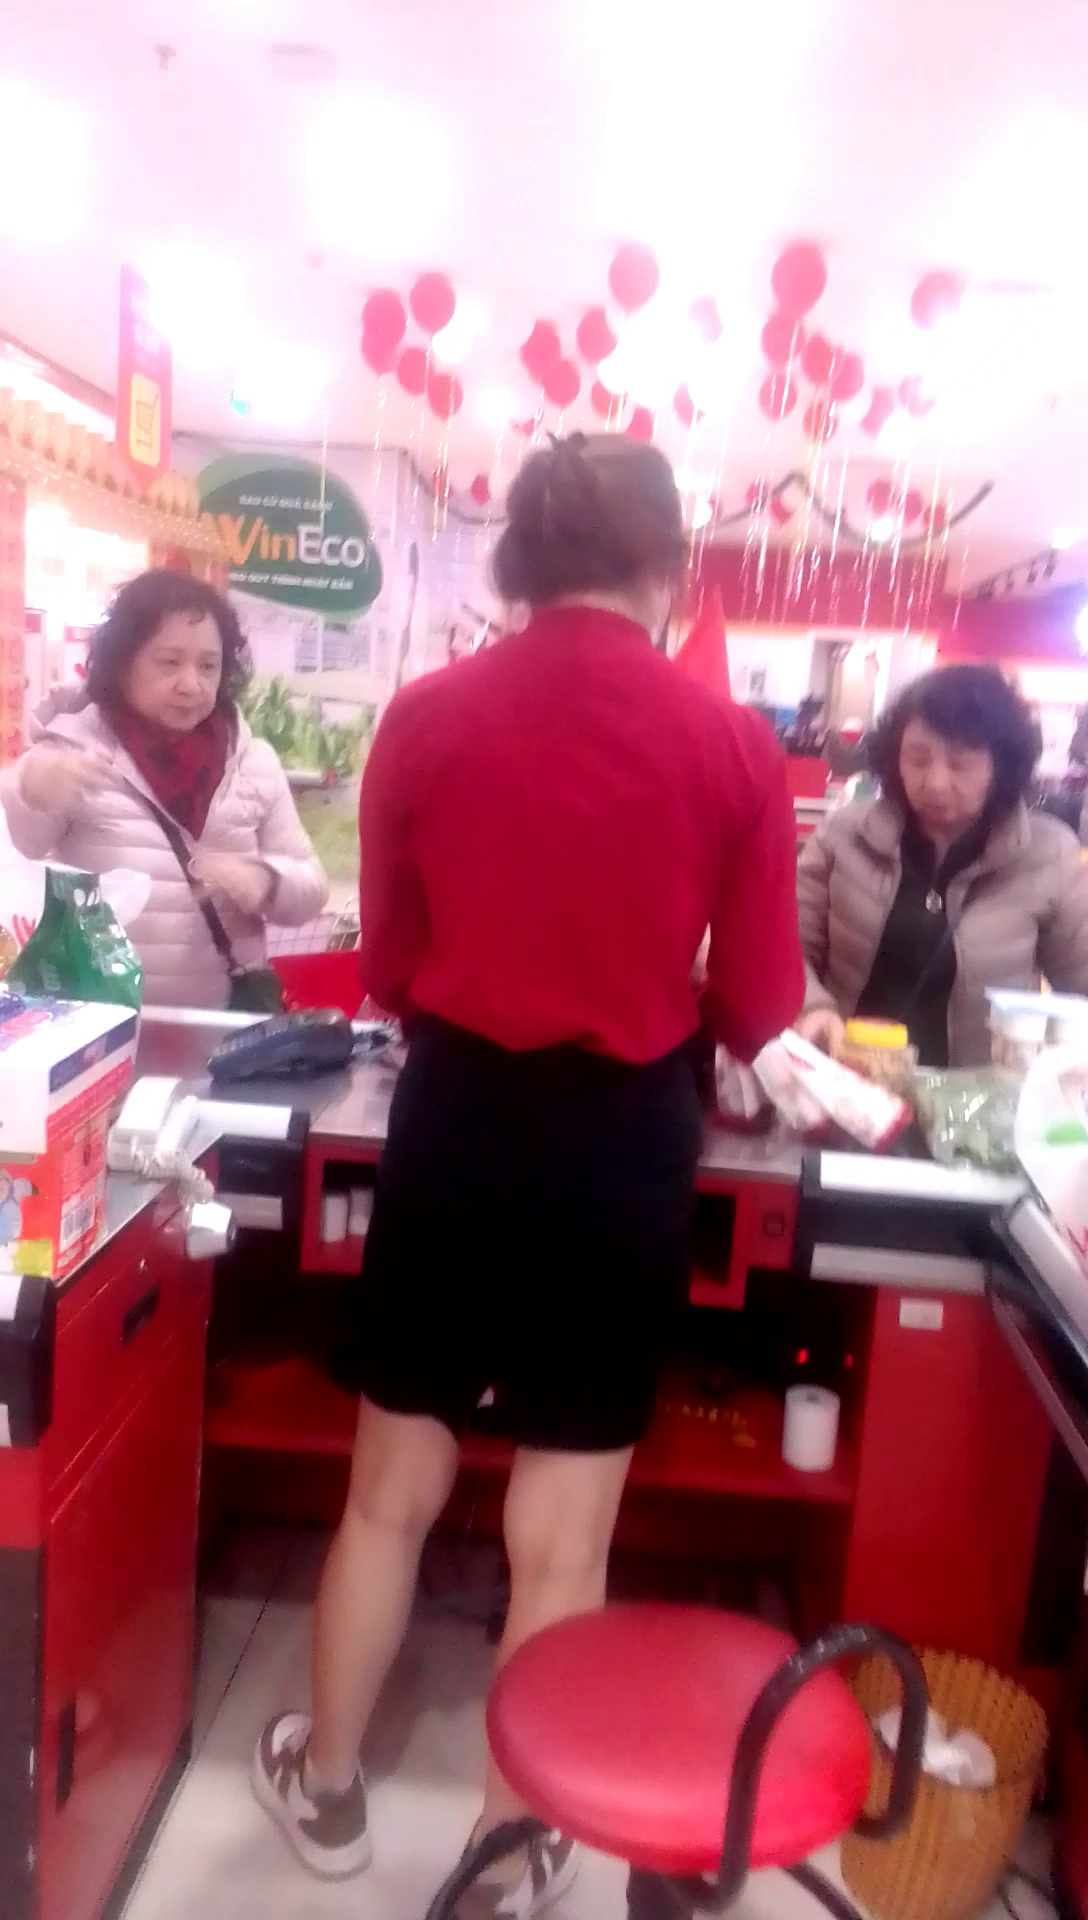

In [133]:
right_vid, right_counts, right_fps, right_sample = load_video(right_video_path, -90)
right_sample

In [134]:
if left_sample.width  > right_sample.width:
    left_sample = left_sample.resize((right_sample.width, right_sample.height))
elif left_sample.width  < right_sample.width:
    right_sample = right_sample.resize((left_sample.width, left_sample.height))

In [135]:
print(left_sample.width, right_sample.width)

720 720


In [136]:
### Function to calculate Bouding Box Area and Range from Center

def center(bbox):
    center_x = (bbox[2] + bbox[0])/2
    center_y = (bbox[3] + bbox[1])/2
    center = [center_x, center_y]
    return center

def dfc(pic, bbox):
    pic_width = pic.width
    pic_height = pic.height
    
    pic_center = center([0,0, pic_width, pic_height])
    bbox_center = center(bbox)
    
    x_dif = bbox_center[0] - pic_center[0]
    y_dif = bbox_center[1] - pic_center[1]
    bbox_width = bbox[2] - bbox[0]
    bbox_height = bbox[3] - bbox[1] 
    distance = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    area = abs(bbox_width * bbox_height)
    return distance, area

In [153]:
def bodyRatio(kp):
    ls = kp[0][5]
    rs = kp[0][6]

    lh = kp[0][11]
    rh = kp[0][12]

    la = kp[0][15]
    ra = kp[0][16]

    def legToBack(s, h, a):
        return (a-h)/(h-s)

    def hipToShoulder(lh, rh, ls, rs):
        return (rh-lh)/(rs-ls)

    legRatio = legToBack(ls[1], lh[1], la[1])
    hipRatio = hipToShoulder(lh[0], rh[0], ls[0], rs[0])
    
    leg_back = legRatio.item()
    hip_shoulder = hipRatio.item()
    
    # Type one
    #     score = round(
    #         (abs(leg_back) - 1 + (abs(hip_shoulder)-0.5)*4),
    #     3)*1000
    #     print(score, leg_back, hip_shoulder)
    
    # Type two
    # score = round(abs(1-(leg_back*hip_shoulder-0.08))*1000, 1)
    
    # Type three
    score = round(leg_back + 2 * hip_shoulder, 2)
    
    points = [ls, rs, lh, rh, la, ra]
    
    print(score, leg_back, hip_shoulder, points)
    
    return score, leg_back, hip_shoulder, points

In [154]:
from PIL import ImageDraw, ImageFont

def addData(image, data): 
    width = image.width
    sample = image.copy()
    draw = ImageDraw.Draw(sample) 
    top_margin = 100

    draw.rectangle(
        [(width/2-200,top_margin), (width/2+200, top_margin+130)], 
        fill="#40389F", 
        outline=None
    )

    title_font = ImageFont.truetype("Roboto-Bold.ttf", 31)
    data_font = ImageFont.truetype("Roboto-Bold.ttf", 41)

    draw.text(
        (width/2-120,top_margin+20),
        "Body Matrix Score",
        fill="#FAFF00",
        font=title_font,
        align="center"
    )

    draw.text(
        (width/2-40,top_margin+60),
        data,
        fill="#FAFF00",
        font=data_font,
        align="center"
    )


    return sample

In [155]:
### Loading Keypoints Models
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model =  keypointrcnn_resnet50_fpn(weights=weights)
transforms = weights.transforms()

model.eval().to("cpu")

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [156]:
### Frame Keypoints Prediction and Visualization
import torch
from torchvision.utils import draw_keypoints, draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor

def detect(pos, frame):
    ### Make Predictions on Frame
    body_matrix = transforms(frame)
    predictions = model([body_matrix.to("cpu")])

    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']

    ### Filter for the main Bounding Box and Keypoints
    idx = torch.where(scores > min_accuracy)
    
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    index = 0
    max_area = 0
    max_distance = frame.width/3

    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox) 
        if distance < max_distance and area > max_area:
            max_area = area
            index = selector
            # print("Selected", area, selector, distance)
        # else:
            # print("Not selected", area, selector, distance)
    
    bx = torch.unsqueeze(boxes[idx][index], dim=0)
    kp = torch.unsqueeze(keypoints[idx][index], dim=0)
    score, legRatio, hipRatio, points = bodyRatio(kp)
    
    labels = [f'SCORE: {score}']
    # print(f"Main Index: {main_index}, Score: {score}")
    
    ### Draw Keypoints and Bounding Boxes
    tensor_image = pil_to_tensor(frame)
    ### keypoints_image = draw_keypoints(tensor_image, kp, colors="yellow", radius=3)
    
    final_image = draw_bounding_boxes(
        tensor_image, 
        bx, 
        colors="blue", 
        fill=True, 
    )
    
    pil_image = to_pil_image(final_image)
    final_image = addData(pil_image, f"{score}")

    return final_image

In [157]:
cd "$output_folder"

/Users/troydo42/Desktop/Body_Matrixes/Dec12


In [158]:
from PIL import Image

def stitch(left_frame, right_frame):
    left_cal = detect("left", left_frame)
    right_cal = detect("right", right_frame)

    width = left_cal.width + right_cal.width
    height = left_cal.height

    left_right = Image.new("RGB",(width, height))
    left_right.paste(im=left_cal, box=(0,0))
    left_right.paste(im=right_cal, box=(left_cal.width, 0))
    return left_right

output = stitch(left_sample, right_sample)

2.92 1.6129028797149658 0.6511631011962891 [tensor([258.4396, 596.9058,   1.0000], grad_fn=<SelectBackward0>), tensor([382.1538, 601.7036,   1.0000], grad_fn=<SelectBackward0>), tensor([277.6201, 805.1255,   1.0000], grad_fn=<SelectBackward0>), tensor([358.1782, 807.0446,   1.0000], grad_fn=<SelectBackward0>), tensor([2.8625e+02, 1.1410e+03, 1.0000e+00], grad_fn=<SelectBackward0>), tensor([3.3900e+02, 1.0584e+03, 1.0000e+00], grad_fn=<SelectBackward0>)]
2.83 1.6402878761291504 0.5931370854377747 [tensor([281.7218, 474.7117,   1.0000], grad_fn=<SelectBackward0>), tensor([477.7480, 491.9923,   1.0000], grad_fn=<SelectBackward0>), tensor([299.9792, 741.6011,   1.0000], grad_fn=<SelectBackward0>), tensor([416.2495, 761.7618,   1.0000], grad_fn=<SelectBackward0>), tensor([2.1926e+02, 1.1794e+03, 1.0000e+00], grad_fn=<SelectBackward0>), tensor([3.4899e+02, 1.1976e+03, 1.0000e+00], grad_fn=<SelectBackward0>)]


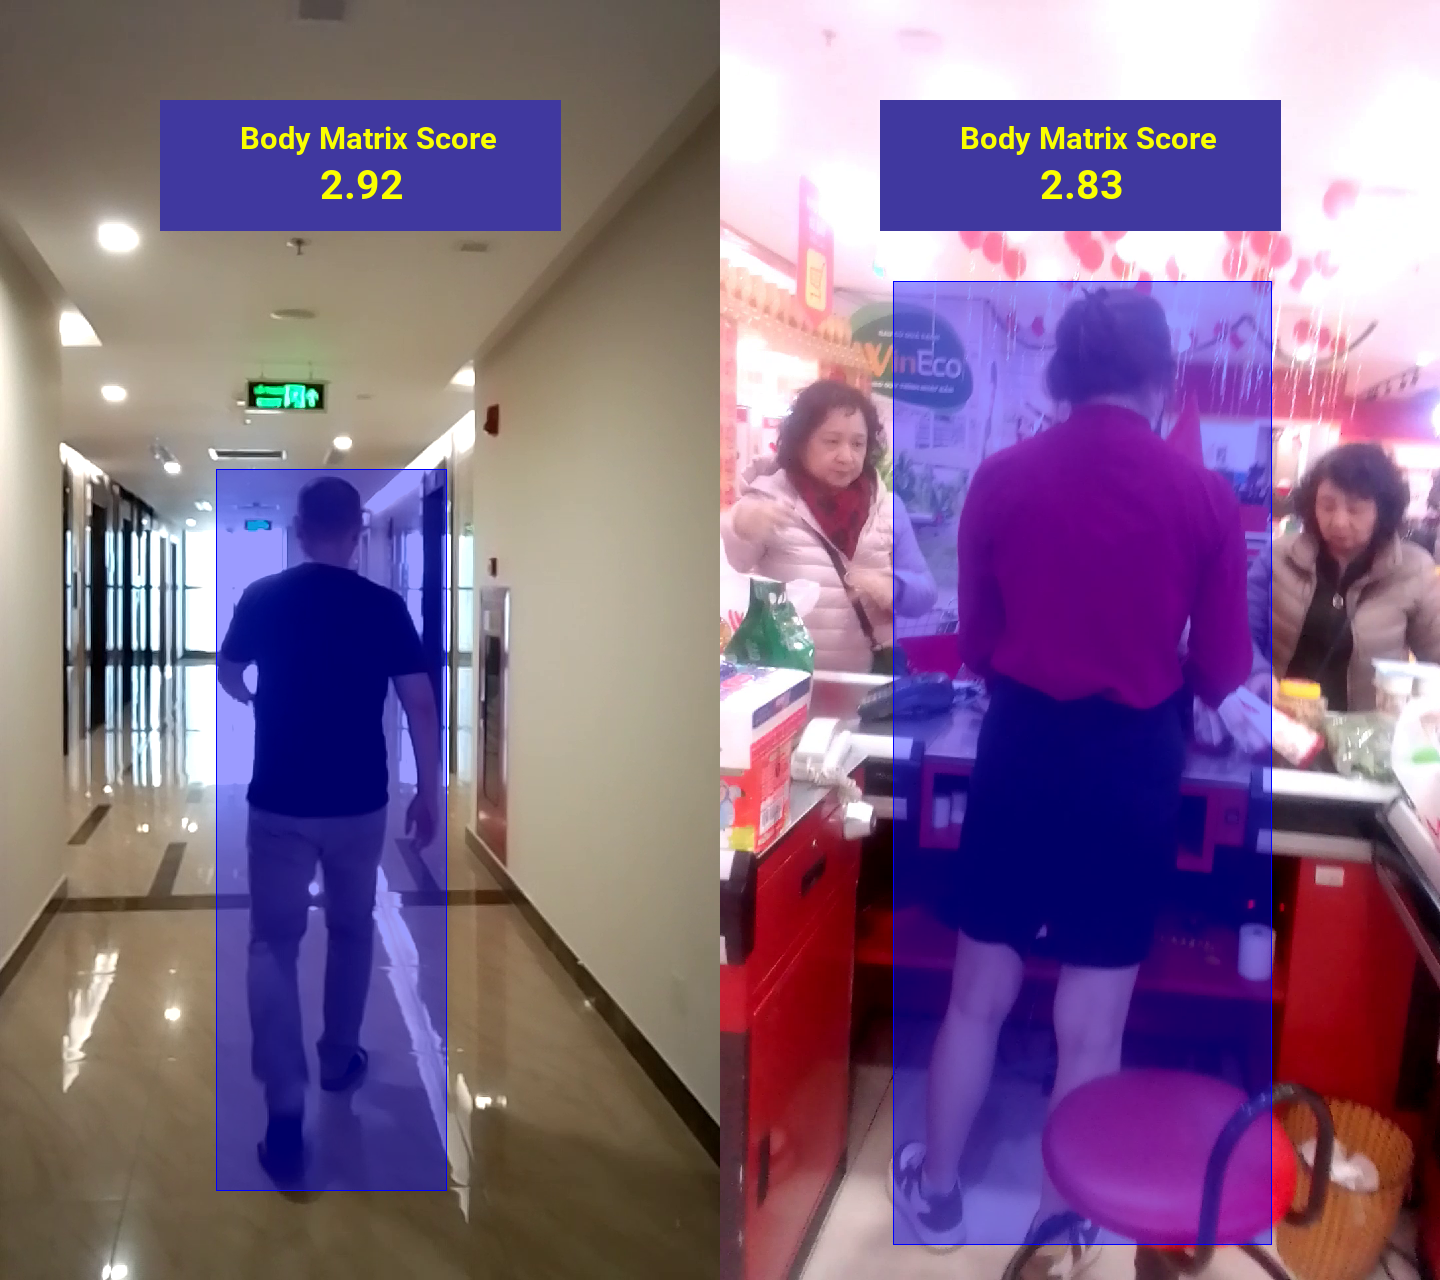

In [159]:
output

In [ ]:
output.save(output_image)

In [ ]:
# def video_processing(left_vid, right_vid):
#     frame_counts = min(len(left_vid), len(right_vid))
#     container = av.open(output_video, mode="w")
#     stream = container.add_stream("mpeg4", rate=math.floor(left_fps))
#     stream.width = output.width
#     stream.height = output.height
    
#     def encode(image):
#         frame = av.VideoFrame.from_image(image)
#         for packet in stream.encode(frame):
#             container.mux(packet)
    
#     for idx in range(frame_counts):
#         print(f"Processing {idx+1} of {frame_counts} ", end="\r")
        
#         left_frame = to_pil_image(left_vid[idx])
#         left_frame = left_frame.rotate(-90, expand=True)
        
#         right_frame = to_pil_image(right_vid[idx])
#         right_frame = right_frame.rotate(-90, expand=True)
        
#         stitched_frame = stitch(left_frame, right_frame)
#         encode(stitched_frame)
    
#     container.close()

In [ ]:
# video_processing(left_vid, right_vid)